## Полносвязные нейронные сети в PyTorch

Задача предсказания года выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd).

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
# загрузка данных
# !wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [ ]:
# деление данных
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [ ]:
X_train

array([[ 4.9943570e+01,  2.1471140e+01,  7.3077500e+01, ...,
        -1.8222300e+00, -2.7463480e+01,  2.2632700e+00],
       [ 4.8732150e+01,  1.8429300e+01,  7.0326790e+01, ...,
         1.2049410e+01,  5.8434530e+01,  2.6920610e+01],
       [ 5.0957140e+01,  3.1856020e+01,  5.5818510e+01, ...,
        -5.8590000e-02,  3.9670680e+01, -6.6345000e-01],
       ...,
       [ 4.4376120e+01,  1.6253100e+00,  3.8165560e+01, ...,
        -4.3994800e+00,  2.2429410e+01, -4.1089300e+00],
       [ 4.4887230e+01,  1.4147600e+01, -5.7069400e+00, ...,
         1.1570710e+01,  1.0661509e+02,  1.6808810e+01],
       [ 5.0322010e+01,  6.7119100e+00,  5.4056070e+01, ...,
         3.7773600e+00, -4.2948880e+01,  5.2780000e-02]])

In [ ]:
X_test

array([[ 45.442  , -30.74976,  31.78587, ...,  -3.86253,  36.424  ,
          7.17309],
       [ 52.67814,  -2.88914,  43.95268, ...,  -4.00966, -68.96211,
         -5.21525],
       [ 45.74235,  12.02291,  11.03009, ..., -10.92522,  26.75348,
         -5.78743],
       ...,
       [ 45.12852,  12.65758, -38.72018, ...,  -6.07171,  53.96319,
         -8.09364],
       [ 44.16614,  32.38368,  -3.34971, ...,  20.3224 ,  14.83107,
         39.74909],
       [ 51.85726,  59.11655,  26.39436, ...,  -5.51512,  32.35602,
         12.17352]])

Вывод данных показал, что они не пригодны для работы без изменений (есть отрицательные значения, которые не отмасштабированы; разная размерность, где-то большие числа, а где-то 0.075). Следовательно, данные нужно скейлить.

#### Обучение `Ridge` регрессии в качестве бейзлайна


In [ ]:
import os

In [ ]:
# функция для фиксирования random_seed для воспроизводимости результатов
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [ ]:
set_random_seed(42)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
# предобработка данных при помощи StandardScaler
X_train = scaler.fit_transform(X_train)
X_train

array([[ 1.07878578,  0.3915658 ,  1.82696245, ..., -0.47047696,
        -0.25536649,  0.04263679],
       [ 0.87951065,  0.33263074,  1.74896068, ...,  0.57086074,
         0.20934068,  1.16111783],
       [ 1.24551515,  0.59277085,  1.33754998, ..., -0.33808131,
         0.10782848, -0.09012209],
       ...,
       [ 0.16295616,  0.00705667,  0.83696599, ..., -0.66394994,
         0.01455343, -0.24641243],
       [ 0.2470323 ,  0.24967363, -0.40712469, ...,  0.53492495,
         0.46999692,  0.7024367 ],
       [ 1.14103808,  0.10560857,  1.28757254, ..., -0.05011829,
        -0.33914232, -0.05763319]])

In [ ]:
X_test = scaler.transform(X_test)
X_test

array([[ 0.33829038, -0.62020406,  0.65605739, ..., -0.62364135,
         0.09026399,  0.26535103],
       [ 1.52861474, -0.08040993,  1.00107112, ..., -0.63468633,
        -0.47987357, -0.29659618],
       [ 0.38769709,  0.20850817,  0.06748658, ..., -1.15383427,
         0.03794659, -0.32255083],
       ...,
       [ 0.28672381,  0.22080478, -1.34327979, ..., -0.78948349,
         0.18515079, -0.42716277],
       [ 0.12841505,  0.60299416, -0.34028082, ...,  1.19191033,
        -0.0265535 ,  1.74303022],
       [ 1.39358232,  1.12093836,  0.50317056, ..., -0.74770053,
         0.06825626,  0.49217542]])

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

In [ ]:
set_random_seed(42)

model = Ridge()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

rmse_on_train = root_mean_squared_error(y_train, model.predict(X_train))
rmse_for_model = root_mean_squared_error(y_test, predictions)

print('RMSE on train:', rmse_on_train)
print('RMSE for model:', rmse_for_model)

RMSE on train: 9.552822967970322
RMSE for model: 9.510160820470436


Подсчет качества при наилучшем константном прогнозе. Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем.

In [ ]:
mean_target = y_train.mean()
mean_target
# для предсказания беру среднее значение таргета в обучающей выборке, т.к. таргеты в тестовой выборке нам как бы неизвестны

1998.3860949074324

In [ ]:
const_pred = np.full((X_test.shape[0], 1), mean_target)
const_pred
# растягиваю среднее значение на массив, у которого первая размерность такая же, как у X_test (ответов столько, сколько объектов), а вторая - 1

array([[1998.38609491],
       [1998.38609491],
       [1998.38609491],
       ...,
       [1998.38609491],
       [1998.38609491],
       [1998.38609491]])

In [ ]:
best_rmse_metric = root_mean_squared_error(y_test, const_pred)
best_rmse_metric
# ошибка увеличилась, качество ухудшилось

10.85246390513634

#### Реализация цикла обучения модели линейной регрессии

In [ ]:
# лосс-функция
def MSELoss(y_pred: torch.Tensor,
            y_true: torch.Tensor) -> torch.Tensor:

    return torch.mean((y_pred - y_true) ** 2)

In [ ]:
# 1 вариант (обучение на срезе данных, без даталоудера)

set_random_seed(42)

# создание модели линейной регрессии, состоящей из одного линейного слоя
linreg = nn.Linear(90, 1)
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []

# для ускорения вычислений и обучения модели взяла срез данных (1000 рандомных объектов)
random_inxs_train = np.random.choice(X_train.shape[0], 1000, replace=False)
slice_train = X_train[random_inxs_train, :]
slice_y_train = y_train[random_inxs_train]

random_inxs_test = np.random.choice(X_test.shape[0], 1000, replace=False)
slice_test = X_test[random_inxs_test, :]
slice_y_test = y_test[random_inxs_test]

# реализация рукописного цикла обучения
for epoch in range(10):

  for i in range(1000):

    y_pred = linreg(torch.from_numpy(slice_train.astype(np.float32)))
    loss = MSELoss(y_pred, torch.from_numpy(slice_y_train))
    # подсчет градиента
    loss.backward()

    # обновление весов (шаг градиентного спуска)
    linreg.weight.data -= 0.01 * linreg.weight.grad.data
    linreg.bias.data -= 0.01 * linreg.bias.grad.data

    # зануление градиентов
    linreg.weight.grad.data.zero_()
    linreg.bias.grad.data.zero_()

  # проверка значения целевой метрики на тестовой выборке после эпохи
  with torch.no_grad():

    # подсчет лосса и метрики для трейна
    y_pred_train = linreg(torch.from_numpy(slice_train.astype(np.float32)))
    loss_train = MSELoss(y_pred_train, torch.from_numpy(slice_y_train))
    train_losses.append(loss_train.numpy())

    rmse_train = torch.sqrt(loss_train)
    train_metrics.append(rmse_train.numpy())

    # подсчет лосса и метрики для теста
    y_pred_test = linreg(torch.from_numpy(slice_test.astype(np.float32)))
    loss_test = MSELoss(y_pred_test, torch.from_numpy(slice_y_test))
    test_losses.append(loss_test.numpy())

    rmse_test = torch.sqrt(loss_test)
    test_metrics.append(rmse_test.numpy())
    print(f'RMSE on test, {epoch} epoch', rmse_test.numpy())

RMSE on test, 0 epoch 12.936544
RMSE on test, 1 epoch 10.946573
RMSE on test, 2 epoch 10.781008
RMSE on test, 3 epoch 10.763196
RMSE on test, 4 epoch 10.761193
RMSE on test, 5 epoch 10.760966
RMSE on test, 6 epoch 10.7609415
RMSE on test, 7 epoch 10.76094
RMSE on test, 8 epoch 10.76094
RMSE on test, 9 epoch 10.76094


In [ ]:
# значения функции потерь на тестовой и обучающей выборке
print('Losses on train:', *train_losses)
print('Losses on test:', *test_losses)

Losses on train: 143.59184 120.10799 118.26814 118.06615 118.042816 118.04001 118.039665 118.03962 118.039604 118.039604
Losses on test: 167.35419 119.82748 116.230125 115.84639 115.80328 115.798386 115.79787 115.79781 115.79782 115.79783


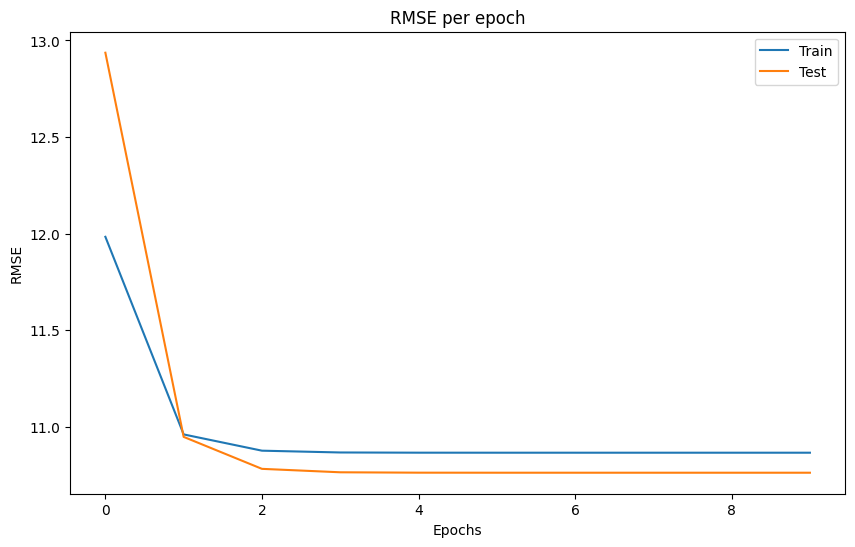

In [ ]:
# графики метрики на тестовой и обучающей выборке
fig = plt.figure(figsize=(10, 6))
plt.plot([x for x in range(10)], train_metrics)
plt.plot([x for x in range(10)], test_metrics)
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.title('RMSE per epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [ ]:
# 2 вариант (с даталоудером)

set_random_seed(42)

from torch.utils.data import TensorDataset, DataLoader

linreg = nn.Linear(90, 1)

train_data = TensorDataset(torch.from_numpy(X_train.astype(np.float32)), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test))

train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=256, shuffle=False)

train_losses = []
test_losses = []
train_metrics = []
test_metrics = []

for epoch in range(10):

    # Обучение
    train_loss = []
    for x_train, y_train in train_loader:

        y_pred = linreg(x_train)
        loss = MSELoss(y_pred, y_train)
        train_loss.append(loss.detach())
        loss.backward()

        # обновление весов
        linreg.weight.data -= 0.0001 * linreg.weight.grad.data
        linreg.bias.data -= 0.0001 * linreg.bias.grad.data

        # зануление градиентов
        linreg.weight.grad.data.zero_()
        linreg.bias.grad.data.zero_()

    # Валидация
    test_loss = []
    with torch.no_grad():

      for x_test, y_test in test_loader:

        y_pred = linreg(x_test)
        loss = MSELoss(y_pred, y_test)
        test_loss.append(loss)

    loss_train_per_epoch = np.mean(train_loss)
    loss_test_per_epoch = np.mean(test_loss)

    train_losses.append(loss_train_per_epoch)
    test_losses.append(loss_test_per_epoch)

    train_metrics.append(np.sqrt(loss_train_per_epoch))
    test_metrics.append(np.sqrt(loss_test_per_epoch))

    print(f'RMSE on test, {epoch} epoch', np.sqrt(loss_test_per_epoch))

RMSE on test, 0 epoch 1390.8981
RMSE on test, 1 epoch 968.10645
RMSE on test, 2 epoch 673.83777
RMSE on test, 3 epoch 469.08145
RMSE on test, 4 epoch 326.5718
RMSE on test, 5 epoch 227.4445
RMSE on test, 6 epoch 158.51918
RMSE on test, 7 epoch 110.621735
RMSE on test, 8 epoch 77.413055
RMSE on test, 9 epoch 54.464466


In [ ]:
print('Losses on train:', *train_losses)
print('Losses on test:', *test_losses)

# лоссы можно было бы получить поменьше, увеличив лернинг рейт, но тогда график получался менее красивый
# поскольку цель - реализовать рабочий цикл обучения, в данном случае оставила так

Losses on train: 2841460.5 1376393.0 666754.25 323022.1 156526.23 75878.85 36815.56 17894.633 8729.651 4290.149
Losses on test: 1934597.4 937230.1 454057.34 220037.4 106649.15 51731.0 25128.332 12237.168 5992.7817 2966.3782


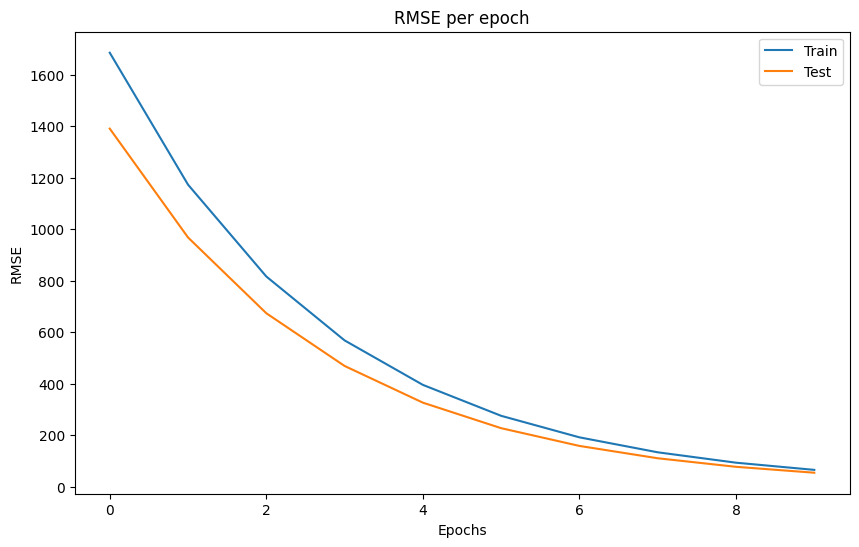

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot([x for x in range(10)], train_metrics)
plt.plot([x for x in range(10)], test_metrics)
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.title('RMSE per epoch')
plt.legend(['Train', 'Test'])
plt.show()

#### Реализация пайплана обучения и тестирования нейронной сети на PyTorch для предоставленного набора данных


In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [ ]:
class dataset(Dataset):

  def __init__(self, X, y):
    self.X = torch.from_numpy(X.astype(np.float32))
    self.y = torch.from_numpy(y.astype(np.float32))

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx, :], self.y[idx]

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [ ]:
# масштабирование признаков
X_train = scaler.fit_transform(X_train)
X_train

array([[ 1.07878578,  0.3915658 ,  1.82696245, ..., -0.47047696,
        -0.25536649,  0.04263679],
       [ 0.87951065,  0.33263074,  1.74896068, ...,  0.57086074,
         0.20934068,  1.16111783],
       [ 1.24551515,  0.59277085,  1.33754998, ..., -0.33808131,
         0.10782848, -0.09012209],
       ...,
       [ 0.16295616,  0.00705667,  0.83696599, ..., -0.66394994,
         0.01455343, -0.24641243],
       [ 0.2470323 ,  0.24967363, -0.40712469, ...,  0.53492495,
         0.46999692,  0.7024367 ],
       [ 1.14103808,  0.10560857,  1.28757254, ..., -0.05011829,
        -0.33914232, -0.05763319]])

In [ ]:
X_test = scaler.transform(X_test)
X_test

array([[ 0.33829038, -0.62020406,  0.65605739, ..., -0.62364135,
         0.09026399,  0.26535103],
       [ 1.52861474, -0.08040993,  1.00107112, ..., -0.63468633,
        -0.47987357, -0.29659618],
       [ 0.38769709,  0.20850817,  0.06748658, ..., -1.15383427,
         0.03794659, -0.32255083],
       ...,
       [ 0.28672381,  0.22080478, -1.34327979, ..., -0.78948349,
         0.18515079, -0.42716277],
       [ 0.12841505,  0.60299416, -0.34028082, ...,  1.19191033,
        -0.0265535 ,  1.74303022],
       [ 1.39358232,  1.12093836,  0.50317056, ..., -0.74770053,
         0.06825626,  0.49217542]])

In [ ]:
# нормировка таргета для улучшения качества модели
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_train

array([0.23893634, 0.23893634, 0.23893634, ..., 0.78739469, 0.69598496,
       0.78739469])

In [ ]:
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()
y_test

array([0.78739469, 0.42175579, 0.60457524, ..., 0.69598496, 0.69598496,
       0.60457524])

In [ ]:
# !pip install wandb --upgrade --quiet

In [ ]:
# import wandb

In [ ]:
# !wandb login

In [ ]:
set_random_seed(42)

epochs = 30
batch_size = 256

train_set = dataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = dataset(X_test, y_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

model = nn.Sequential(nn.Linear(90, 64), nn.LeakyReLU(0.1), nn.Dropout(0.22), nn.Linear(64, 32), nn.LeakyReLU(0.1), nn.Linear(32, 1))
optimizer = torch.optim.AdamW(model.parameters(), 1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-4)
criterion = nn.MSELoss(reduction='sum')

model.to(device)

Sequential(
  (0): Linear(in_features=90, out_features=64, bias=True)
  (1): LeakyReLU(negative_slope=0.1)
  (2): Dropout(p=0.22, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): LeakyReLU(negative_slope=0.1)
  (5): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
def train(model, optimizer, criterion, train_loader, test_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set (for validation during training)
    """

    best_loss = 1e3
    best_model = None
    train_losses = []   # лоссы на трейне на каждой эпохе
    test_losses = []    # лоссы на тесте на каждой эпохе

    # wandb.init(
    #     project="01_FCNN",
    #     config={
    #         "epochs": epochs,
    #         "batch_size": batch_size,
    #         "device": device,
    #         "model": model
    #     }
    # )

    for epoch in range(epochs):

        # обучение
        train_loss = []   # список лоссов по батчам
        # (лосс на батче считаю как просто сумму квадратов, усредняю уже после суммирования по всем батчам,
        # потому что не все батчи имеют одинаковый размер и нужно учесть это в подсчете общего лосса)

        model.train()
        for x_train, y_train in tqdm(train_loader): # создание прогресс-баров при помощи библиотеки `tqdm` для отслеживания прогресса обучения
            y_pred = model(x_train.to(device))
            loss = criterion(y_pred, y_train.unsqueeze(-1).to(device))
            train_loss.append(loss.detach().cpu())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        scheduler.step()

        # валидация
        test_loss = []    # список для лоссов по батчам

        model.eval()
        with torch.no_grad():

            for x_test, y_test in tqdm(test_loader):
                y_pred = model(x_test.to(device))
                loss = criterion(y_pred, y_test.unsqueeze(-1).to(device))
                test_loss.append(loss.cpu().numpy())

        train_loss_per_epoch = np.sqrt(np.sum(train_loss) / len(train_set))   # rmse на трейне на эпохе как корень от среднего суммы квадратов по батчам
        test_loss_per_epoch = np.sqrt(np.sum(test_loss) / len(test_set))   # rmse на тесте на эпохе
        train_losses.append(train_loss_per_epoch)
        test_losses.append(test_loss_per_epoch)

        if test_loss_per_epoch < best_loss:
            best_model = model
            best_loss = test_loss_per_epoch
            print(f"Сохранение лучшей модели с RMSE = {test_loss_per_epoch}")

        print(f'Epoch {epoch}, RMSE: {test_loss_per_epoch}')

        # wandb.log({
        #     "epoch": epoch,
        #     "train_loss": train_loss_per_epoch,
        #     "test_loss": test_loss_per_epoch,
        #     "best_loss": best_loss
        #     }
        # )

    return best_model, train_losses, test_losses


def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """

    targets = []
    predicts = []

    model.eval()
    with torch.no_grad():
        for x_test, y_test in tqdm(test_loader):
            y_pred = model(x_test.to(device))
            y_pred = torch.from_numpy(scaler.inverse_transform(y_pred.cpu().numpy())).squeeze()   # предсказание нормирую обратно
            predicts.append(y_pred)
            y_test = torch.from_numpy(scaler.inverse_transform(y_test.numpy().reshape(-1, 1))).squeeze()
            targets.append(y_test)

    predicts = torch.cat(predicts)    # список с предиктами превращаю в тензор
    targets = torch.cat(targets)

    print(f'RMSE: {torch.sqrt((criterion(predicts, targets)) / len(test_set))}')
    return predicts

In [ ]:
set_random_seed(42)
best_model, train_losses, test_losses = train(model, optimizer, criterion, train_loader, test_loader)

  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Сохранение лучшей модели с RMSE = 0.8137837375667943
Epoch 0, RMSE: 0.8137837375667943


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Сохранение лучшей модели с RMSE = 0.8104049330909532
Epoch 1, RMSE: 0.8104049330909532


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Сохранение лучшей модели с RMSE = 0.8080906217638972
Epoch 2, RMSE: 0.8080906217638972


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Сохранение лучшей модели с RMSE = 0.8042020474243657
Epoch 3, RMSE: 0.8042020474243657


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch 4, RMSE: 0.8052073118935671


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Сохранение лучшей модели с RMSE = 0.8040009283936397
Epoch 5, RMSE: 0.8040009283936397


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Сохранение лучшей модели с RMSE = 0.8039123730238711
Epoch 6, RMSE: 0.8039123730238711


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Сохранение лучшей модели с RMSE = 0.8028134654717893
Epoch 7, RMSE: 0.8028134654717893


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch 8, RMSE: 0.8031907678282297


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch 9, RMSE: 0.8068293338668293


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch 10, RMSE: 0.8038417381826772


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Сохранение лучшей модели с RMSE = 0.8020643654168583
Epoch 11, RMSE: 0.8020643654168583


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Сохранение лучшей модели с RMSE = 0.8011218347250393
Epoch 12, RMSE: 0.8011218347250393


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Сохранение лучшей модели с RMSE = 0.800795192085255
Epoch 13, RMSE: 0.800795192085255


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch 14, RMSE: 0.8008924053363417


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Сохранение лучшей модели с RMSE = 0.7999233353191707
Epoch 15, RMSE: 0.7999233353191707


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch 16, RMSE: 0.8015647337671089


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch 17, RMSE: 0.8002768055943779


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch 18, RMSE: 0.80105987920967


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch 19, RMSE: 0.8018214766960247


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Сохранение лучшей модели с RMSE = 0.7996272381420574
Epoch 20, RMSE: 0.7996272381420574


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch 21, RMSE: 0.8004525370025396


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch 22, RMSE: 0.8010457591039257


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Сохранение лучшей модели с RMSE = 0.7996253931035157
Epoch 23, RMSE: 0.7996253931035157


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch 24, RMSE: 0.8004000295882704


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch 25, RMSE: 0.7998150786330025


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch 26, RMSE: 0.8000260923106702


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch 27, RMSE: 0.7997630496738821


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Сохранение лучшей модели с RMSE = 0.7994306466347226
Epoch 28, RMSE: 0.7994306466347226


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch 29, RMSE: 0.79993695504416


In [ ]:
# проверка того, что вектор предсказаний состоит из нужного количества чисел
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

  0%|          | 0/202 [00:00<?, ?it/s]

RMSE: 8.751113891601562


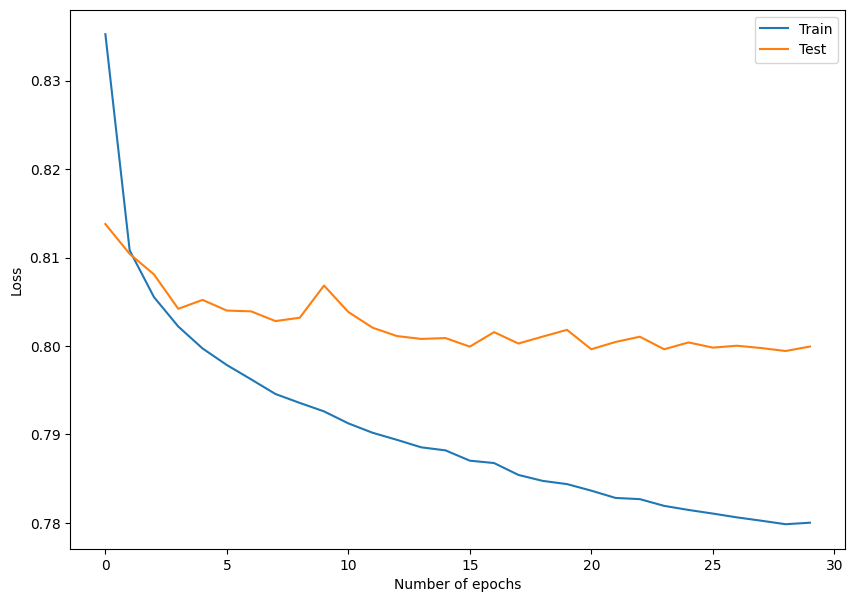

In [ ]:
# графики зависимости лосса на обучающей и тестовой выборках в зависимости от времени обучения (зависимость по эпохам)

plt.figure(figsize=(10,7))
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), test_losses)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

#### Отчет об экспериментах

0) Начала попытки с:

epochs = 30, batch_size = 256

model = nn.Sequential(nn.Linear(90, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, 1))

optimizer = torch.optim.SGD(model.parameters(), 1e-5)

**RMSE: 9.970963**

1) _с нормировкой таргета_

RMSE: 10.763088

Ошибка увеличилась, поэтому решила поменять в этом эксперименте еще и _оптимизатор_. Поставив Adam вместо SGD получила RMSE: 8.961112. Попробовала также AdamW, траектория его обучения оказалась такой же, как у Adam, но он показал немного лучшее качество.

**RMSE: 8.960381**

2) далее добавила _шедулер_ (оптимизатор оставила AdamW с lr=1e-5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

т.к. качество ухудшилось (RMSE: 9.0484619140625), решила увеличить _шаг_, задав начальное значение 1e-3 и минимальное 1e-4, это также не помогло (RMSE: 9.110158). Проводя эксперименты с оптимизаторами, шедулерами, коэффициентами обучения, решила попробовать поменять _архитектуру_, т.к. есть вероятность что архитектура типа 90 -> 128 -> 64 -> 64 -> 1 переобучается. Чтобы убедить себя в этом уменьшила количество нейронов (оставив при этом шедулер и шаг) и видно, что метрика стала меньше:

- model = nn.Sequential(nn.Linear(90, 64), nn.ReLU(), nn.Linear(64, 32), nn.ReLU(), nn.Linear(32, 1))

в результате получила качество RMSE: 8.932487, обрадовалась и попробовала другую архитектуру:

- model = nn.Sequential(nn.Linear(90, 64), nn.ReLU(), nn.Linear(64, 16), nn.ReLU(), nn.Linear(16, 1))

**RMSE: 8.895427**


3) теперь решила поиграться с _функциями активации_ и _дропаутом_

До этого я работала с функцией активацией ReLu, но мы знаем, что она зануляет отрицательную область значений, что приводит к потере некоторой информации. Из логических соображений попробовала использовать модификации функции ReLu, а именно LeakyRelu, которая не зануляет отрицательную область и с небольшим углом наклона строит прямую в отрицательной области, что позвоялет отрицательным значениям вносить вклад в общее предсказание и PReLu, которая так же как и LeakyReLu имеет прямую в отрицательной области значений, но угол наклона не является постоянным параметром, а он обучаемый.

|| Experiments | RMSE |
| :---: | :---: | :---: |
|1| nn.PReLU()| 8.895224 |
|2| nn.LeakyReLU(0.1) | 8.891015 |
|3| nn.Dropout(0.25) | 8.75997 |
|3| nn.Dropout(0.2) | 8.756997 |

снова решила поменять линейные слои на 90 -> 64 -> 32 -> 1, получила архитектуру:

model = nn.Sequential(nn.Linear(90, 64), nn.LeakyReLU(0.1), nn.Dropout(0.25), nn.Linear(64, 32), nn.LeakyReLU(0.1), nn.Linear(32, 1))

RMSE: 8.759022, с дропаутом 0.2 RMSE: 8.755260. Изменив параметр дропаута на 0.21 получила RMSE: 8.7544794, 0.22 - **RMSE: 8.743911**, 0.23 - RMSE: 8.758739.

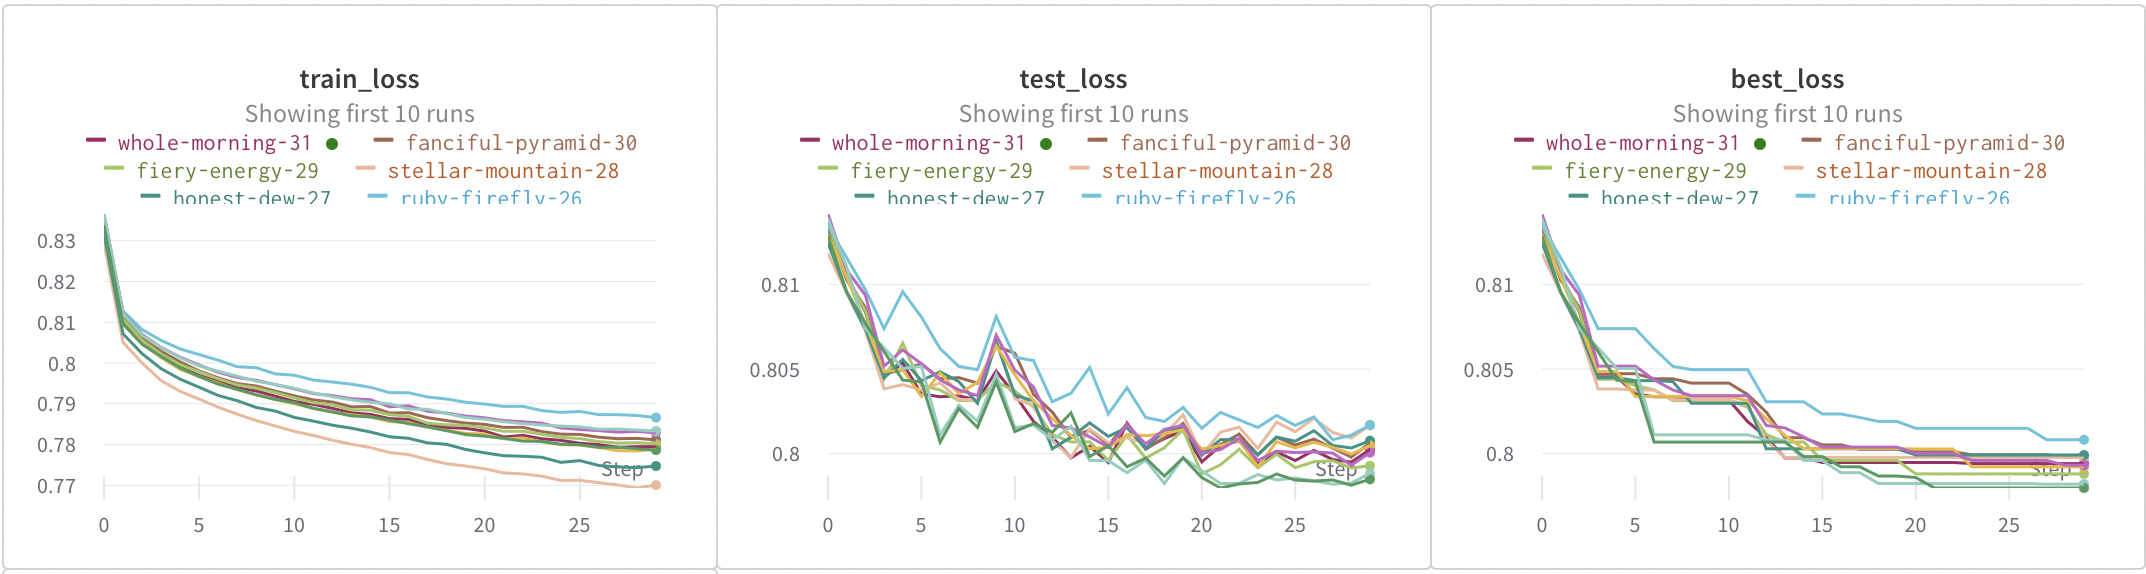